## The transient Universe

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties. <span style="color:blue"> in the file : time  -- quantity -- error on quantity  </span>

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [9]:
#import sys
#!{sys.executable} -m pip install corner
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
import scipy
from scipy import optimize
import scipy.stats as stats
import emcee
import corner

In [10]:
data = np.load("../solutions/transient.npy", "r")
#print(file[:, 0])
#plt.plot(file[:, 0], file[:, 1])
x = data[:, 0]
y = data[:, 1]
sigma_y = data[:,2]

Text(0, 0.5, 'flux')

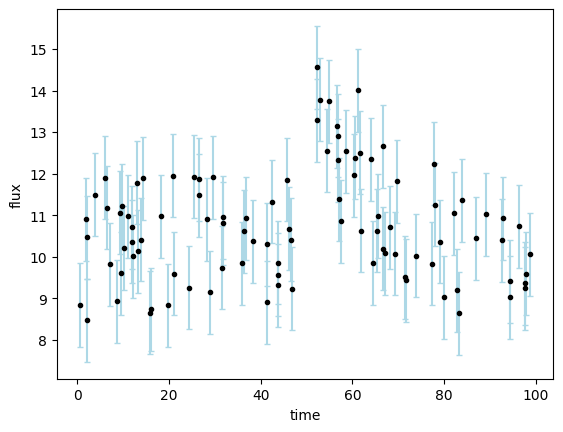

In [11]:
plt.errorbar(x, y, yerr = sigma_y , xerr=None, ecolor='lightblue', fmt= 'o', color = 'black',markersize =3 ,capsize = 2, capthick = 1)
plt.xlabel('time')
plt.ylabel('flux')


One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.


### Looking at the data: I first did a fit to have an idea of the parameters  par = [t0,  b,  A , alpha]
(It's a frequentistic approach...)


In [12]:
def model_ (t, par):
    modello = []
    for time in t:
        if (time < par[0]):
            modello.append(par[1])              
        else:
            modello.append(par[1] + par[2] * np.exp(- par[3] * (time-par[0])))
    
    return modello

In [13]:
#gaussian log likelihood ()
def logL(par, data, model=model_):
    x = data [:,0]
    y = data [:,1]
    sigma_y = data [:,2]

    y_fit = model(x, par)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# parameters which minimize -logL
def best_par(model=model_, data=data):
    par_0 = [48, 10, 4, 1/20]
    
    neg_logL = lambda par : -logL(par, data, model)
    return scipy.optimize.fmin_bfgs(neg_logL, par_0, disp=False)

[47.87171889 10.28787785  6.34817816  0.11890542]


Text(0, 0.5, 'flux')

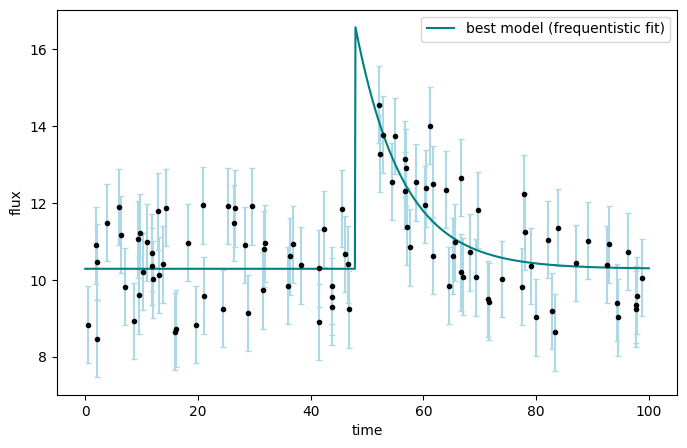

In [14]:
Ndata = x.size

par = best_par(model_, data=data)
print(par)

xgrid = np.linspace(0, 100, 1000)
yfit = model_(xgrid, par)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='lightblue', markersize=3, capsize=2, capthick=1)
ax.plot(xgrid, yfit, label='best model (frequentistic fit)', color='teal')
ax.legend(loc='best', fontsize=10)
ax.set_xlabel('time')
ax.set_ylabel('flux')

In [15]:
np.random.seed(21)
Ndata = x.size

### let's define the prior, uniform pdf 

#### first just to visualize it

[[], [], [], []]


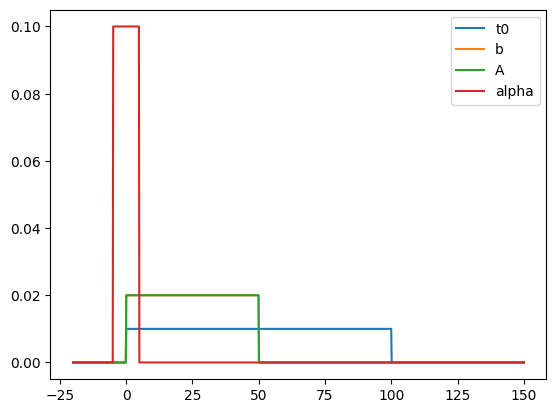

In [16]:
# par = [t0, b, A , alpha]


x_linspace = np.linspace(-20,150, 1000)
par0_mcmc = [[],[],[],[]]
print(par0_mcmc)
def Prior_plot(x):
    for xi in x:
        
        par0_mcmc[0].append(stats.uniform.pdf(xi, loc=0, scale=100))
        par0_mcmc[1].append(stats.uniform.pdf(xi, loc=0, scale=50))
        par0_mcmc[2].append(stats.uniform.pdf(xi, loc=0, scale=50))
        ln_alpha = stats.uniform.pdf(xi, loc=-5, scale=10)
        par0_mcmc[3].append((np.exp(ln_alpha)))
    return par0_mcmc

par0_mcmc = Prior_plot(x_linspace)
    
#plot
plt.plot(x_linspace, par0_mcmc[0], label = 't0' )
plt.plot(x_linspace, par0_mcmc[1], label = 'b' )
plt.plot(x_linspace, par0_mcmc[2], label = 'A' )
plt.plot(x_linspace, np.log(par0_mcmc[3]), label = 'alpha')
plt.legend()
plt.show()

    

#### real prior definition

In [17]:
def Prior(par_mcmc):
    prior_0 = stats.uniform(0,100).pdf(par_mcmc[0])
    prior_1 = stats.uniform(0,50).pdf(par_mcmc[1])
    prior_2 = stats.uniform(0,50).pdf(par_mcmc[2])
    prior_3 = stats.uniform(-5,5).pdf(np.log(par_mcmc[3]))
    
                                      
    return prior_0 * prior_1 * prior_2* prior_3


#### we have already defined the likelihood, let's get the posterior
(actually the log)

In [18]:
def logPosterior (par_mcmc, data, model = model_):
    logPrior = np.log(Prior(par_mcmc))
    if not np.isfinite(logPrior):
        return -np.inf
    return logL(par_mcmc, data, model) + logPrior

### MCMC

In [19]:
ndim = 4  # number of parameters in the model
nwalkers = 10 
nsteps = 5000 
print( "data dimensions: ", np.shape(data))

np.random.seed(0) 
starting_guesses = np.array(par)+ 1e-4* np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=(data, ))

sampler.run_mcmc(starting_guesses, nsteps, progress = True)
print("done")

data dimensions:  (100, 3)


  3%|▎         | 131/5000 [00:20<10:32,  7.69it/s]/tmp/ipykernel_190454/3932712940.py:2: RuntimeWarning: divide by zero encountered in log
  logPrior = np.log(Prior(par_mcmc))
  8%|▊         | 375/5000 [00:57<10:21,  7.44it/s]/tmp/ipykernel_190454/309442965.py:5: RuntimeWarning: invalid value encountered in log
  prior_3 = stats.uniform(-5,5).pdf(np.log(par_mcmc[3]))
100%|██████████| 5000/5000 [11:20<00:00,  7.34it/s]

done


In [20]:
# Save the MCMC results

mcmc_results_file = "mcmc_results.npy"

samples = sampler.get_chain()
thin = int(np.mean(sampler.get_autocorr_time())/2) 
burn = thin*10
emcee_thinned = sampler.get_chain(discard=burn, thin=thin, flat=True)

np.save(mcmc_results_file, sampler.chain, samples, emcee_thinned)


print("MCMC results saved.")

MCMC results saved.


/tmp/ipykernel_190454/198024685.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(samples[:, :, i], "k", alpha=0.5, color = "lightseagreen")


(10, 5000, 4)


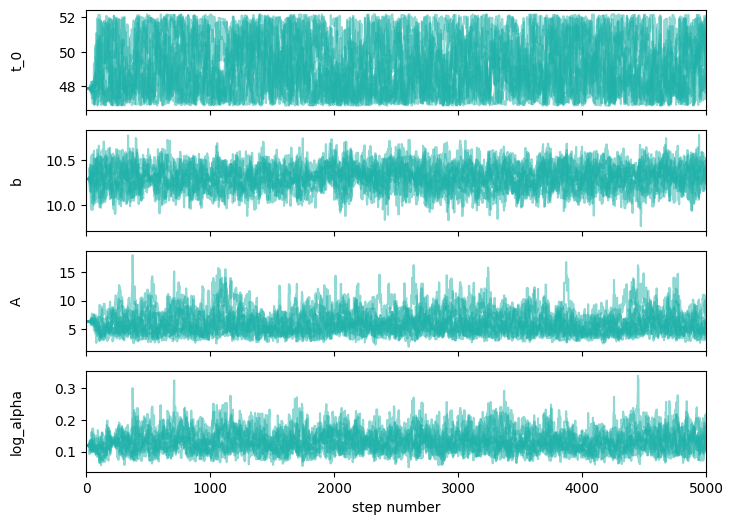

In [21]:
print(sampler.chain.shape) #original chain structure : (nwalkers, nsteps, ndim)

fig, axes = plt.subplots(4, figsize=(8, 6), sharex=True)
samples = sampler.get_chain()
labels = ["t_0", "b","A","log_alpha"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.5, color = "lightseagreen")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### adding a burn-in period  

In [22]:
burn = 200  

emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
print("burned and flattened chain ",emcee_trace.shape) 
emcee_trace.flatten()
len(emcee_trace.flatten())

burned and flattened chain  (48000, 4)


192000

#### thinning ---> take autocorrelation length into account, burn-in is now a few times the autocorrelation length

In [23]:
print(sampler.chain.shape) 
print(sampler.acceptance_fraction)
tau = sampler.get_autocorr_time()
print('autocorrelation time ( how many steps to forget where it started):', tau, "Burn-in will be a few times ", tau[0])
thin = int(np.mean(tau)/2) # thin by  half the autocorrelation time
burn = thin*10

# flatten the thinned chain, to get a flat list of samples
emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).flatten()
print("trace shape:", emcee_trace.shape)


emcee_thinned = sampler.get_chain(discard=burn, thin=thin, flat=True)
print("thinned MC shape: ", emcee_thinned.shape)


(10, 5000, 4)
[0.5268 0.5276 0.544  0.525  0.5388 0.5172 0.535  0.5438 0.5238 0.5464]
autocorrelation time ( how many steps to forget where it started): [77.45302941 62.51928952 71.87195933 68.21193881] Burn-in will be a few times  77.45302941020071
trace shape: (5280,)
thinned MC shape:  (1320, 4)


49.14867836739956


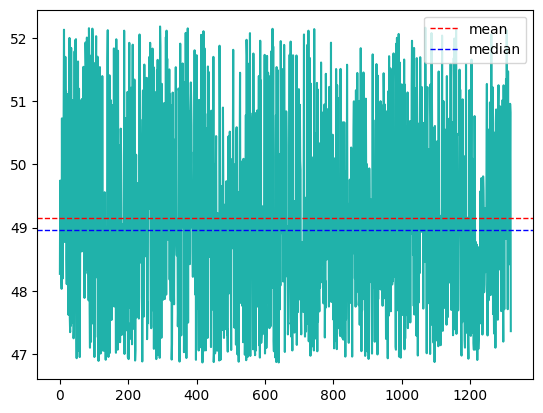

In [24]:
sampler.get_chain(discard=burn, thin=thin, flat=True).shape


plt.plot(emcee_thinned[:,0], color = "lightseagreen")

mean_t0 = np.mean(emcee_thinned[:,0])
print(mean_t0)
median_t0 = np.median(emcee_thinned[:,0])

plt.axhline(mean_t0, color='r', linestyle='dashed', linewidth=1, label = "mean")
plt.axhline(median_t0, color='b', linestyle='dashed', linewidth=1, label = "median")
plt.legend()

### CORNER PLOT

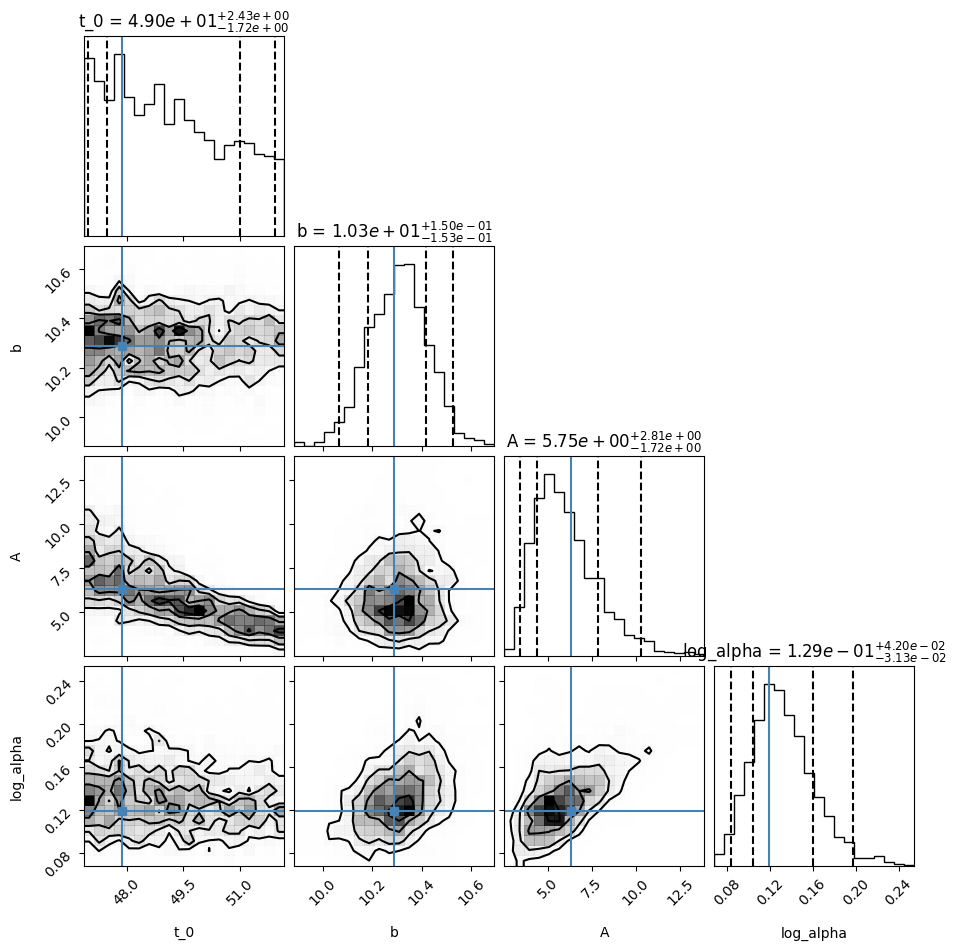

In [25]:
#I don't have the true values, I can plot the values i got from max likelihood estimation
fig = corner.corner(emcee_thinned, labels=labels, truths=par, 
                    quantiles= (0.025, 0.16, 0.84,0.9725), 
                    color = "black", title_quantiles=(0.10, 0.5, 0.90), 
                    show_titles=True, title_fmt='.2e', title_kwargs={"fontsize": 12},
                    plot_contours=True, plot_density=True, plot_datapoints=False, smooth=0.5);

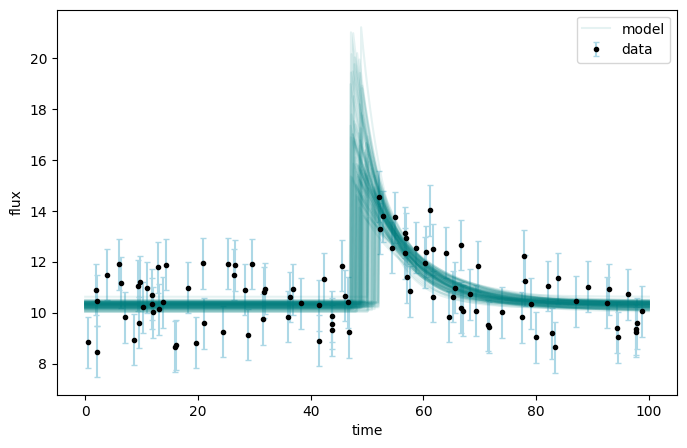

In [26]:
# now I need to choose 100 random samples from the burned, thinned chain
random_samples = np.random.choice(emcee_thinned.shape[0], size=100, replace=False)
selected_samples = emcee_thinned[random_samples]

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='lightblue', markersize=3, capsize=2, capthick=1, label='data')

yfit = model_(xgrid, selected_samples[0])
ax.plot(xgrid, yfit, color='teal', alpha=0.1, label='model')

for sample in selected_samples:
    yfit = model_(xgrid, sample)
    ax.plot(xgrid, yfit, color='teal', alpha=0.1)

ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.legend(loc='best', fontsize=10)
plt.show()

In [27]:
median_t0 = np.median(emcee_thinned[:, 0])
lower_t0 = np.percentile(emcee_thinned[:, 0], 5)
upper_t0 = np.percentile(emcee_thinned[:, 0], 95)
print(f"t_0 = {median_t0:.2f} +{upper_t0 - median_t0:.2f} -{median_t0 - lower_t0:.2f}")

median_b = np.median(emcee_thinned[:, 1])
lower_b = np.percentile(emcee_thinned[:, 1], 5)
upper_b = np.percentile(emcee_thinned[:, 1], 95)
print(f"b = {median_b:.2f} +{upper_b - median_b:.2f} -{median_b - lower_b:.2f}")

median_A = np.median(emcee_thinned[:, 2])
lower_A = np.percentile(emcee_thinned[:, 2], 5)
upper_A = np.percentile(emcee_thinned[:, 2], 95)
print(f"A = {median_A:.2f} +{upper_A - median_A:.2f} -{median_A - lower_A:.2f}")

median_log_alpha = np.median(emcee_thinned[:, 3])
lower_log_alpha = np.percentile(emcee_thinned[:, 3], 5)
upper_log_alpha = np.percentile(emcee_thinned[:, 3], 95)
print(f"log_alpha = {median_log_alpha:.2f} +{upper_log_alpha - median_log_alpha:.2f} -{median_log_alpha - lower_log_alpha:.2f}")



t_0 = 48.97 +2.76 -1.91
b = 10.31 +0.19 -0.19
A = 5.75 +3.72 -2.00
log_alpha = 0.13 +0.06 -0.04


--------------------------------------------
-------------------------------

## LECTURE 12 
### --> Let's do the same but with nested sampling

###  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?


In [29]:
import dynesty


I have my likelihood:
then define the prior as dynesty wants

In [30]:
def model_ (t, par):
    modello = []
    for time in t:
        if (time < par[0]):
            modello.append(par[1])              
        else:
            modello.append(par[1] + par[2] * np.exp(- par[3] * (time-par[0])))
    
    return modello

In [31]:
def prior_transform(u):
    prior_0 = stats.uniform(30,70).ppf(u[0])
    prior_1 = stats.uniform(0,20).ppf(u[1])
    prior_2 = stats.uniform(0,20).ppf(u[2])
    prior_3 = stats.uniform(np.exp(-5),np.exp(2)).ppf(u[3]) ###STIMIAMO ALPHA NON LOG ALPHA
    
                                
    return prior_0, prior_1, prior_2, prior_3

def loglike_normalized(par, data = data, model=model_):

    x = data [:,0]
    y = data [:,1]
    sigma_y = data [:,2]

    y_fit = model(x, par)
       
    return sum ( (stats.norm.logpdf(*args) - np.log(np.sqrt(2*np.pi)*args[2]) for args in zip(y, y_fit, sigma_y)) )

In [32]:
# Nested sampling.
ndim = 4  # number of parameters in the model

sampler = dynesty.NestedSampler(loglike_normalized, prior_transform, ndim, nlive = 1000)
sampler.run_nested()
sresults = sampler.results

14442it [44:41,  5.39it/s, +1000 | bound: 79 | nc: 1 | ncall: 154505 | eff(%): 10.060 | loglstar:   -inf < -232.549 <    inf | logz: -246.892 +/-  0.124 | dlogz:  0.001 >  1.009]


In [33]:
sresults = sampler.results

ns_results_file = "nested_sampling_results.npy"
np.save(ns_results_file, sresults)


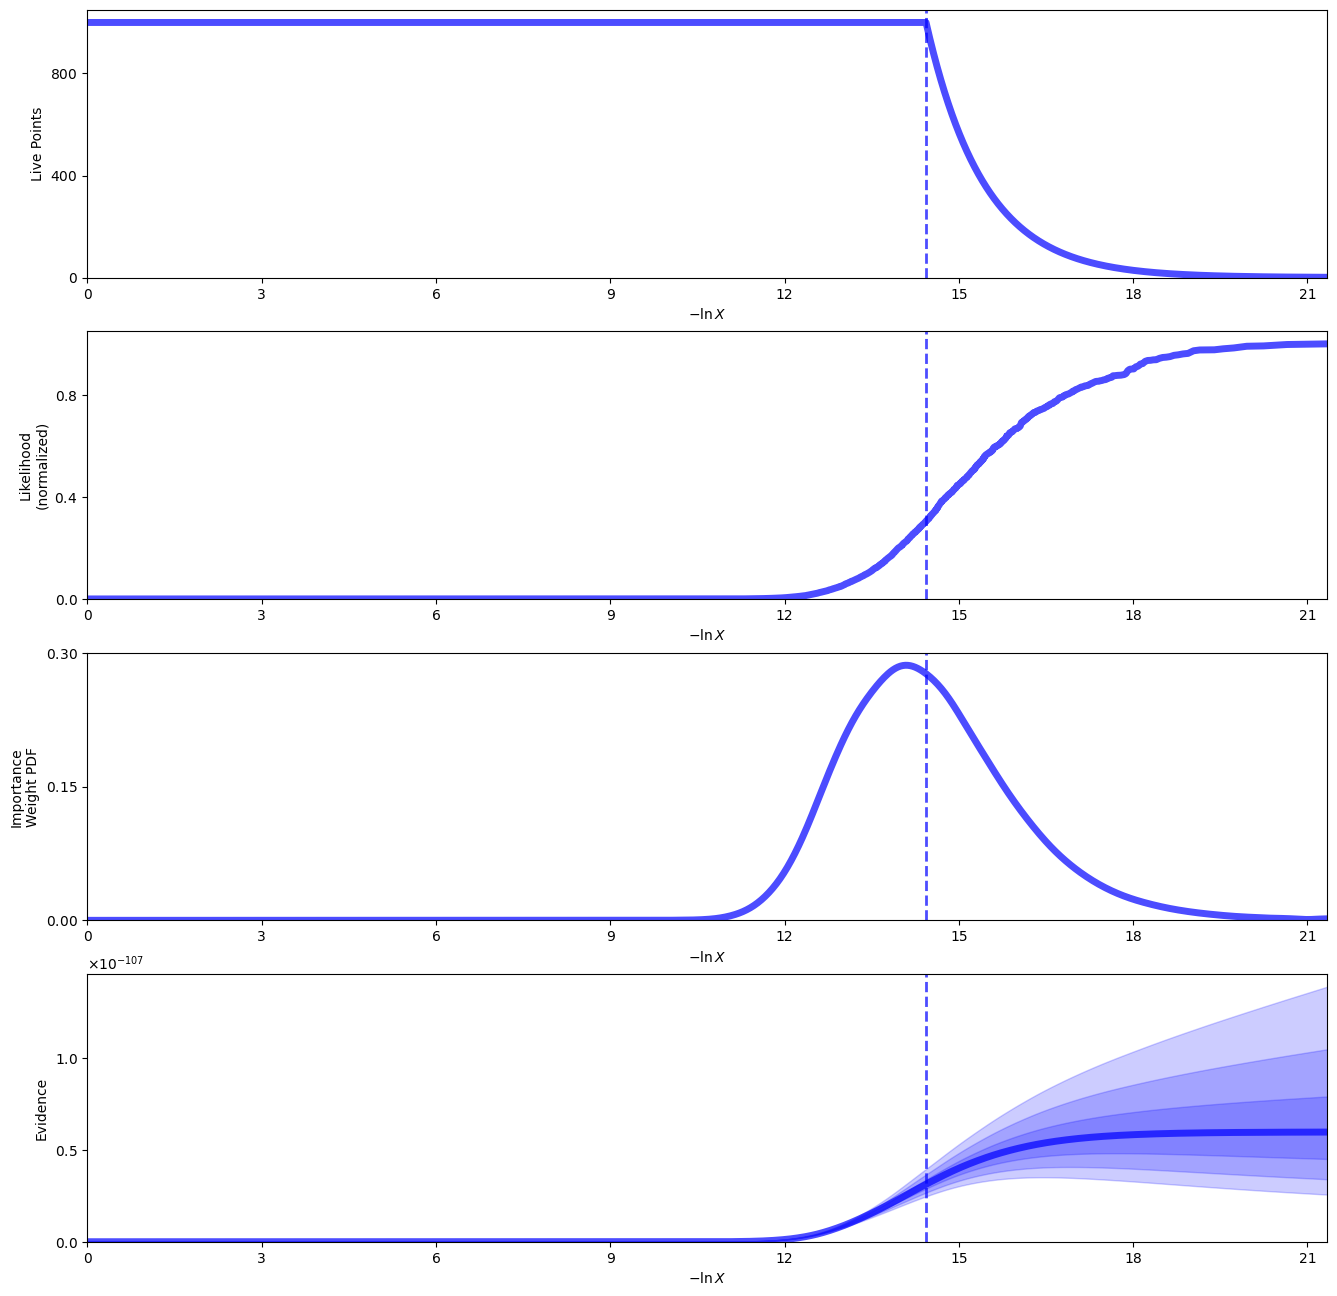

In [34]:
from dynesty import plotting as dyplot
plt.rcParams['figure.figsize'] = (8,8)
rfig, raxes = dyplot.runplot(sresults)

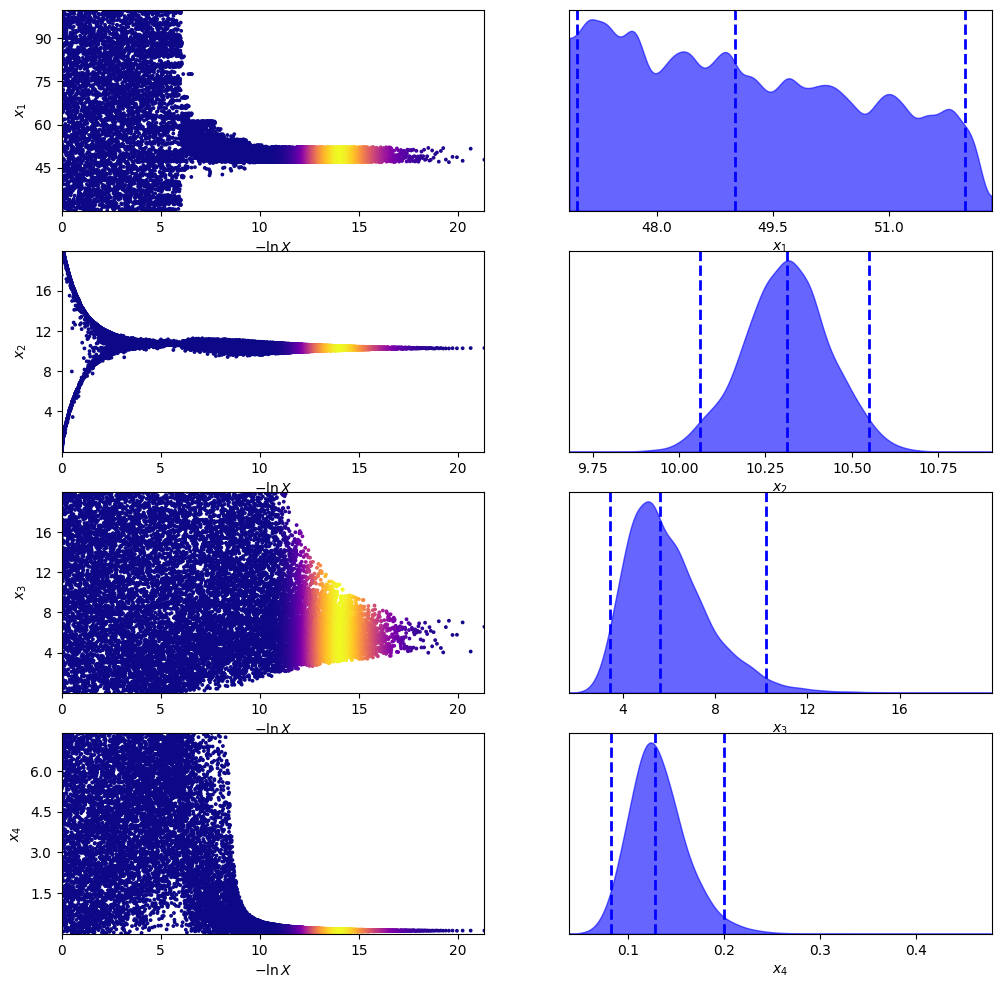

In [35]:
tfig, taxes = dyplot.traceplot(sresults)

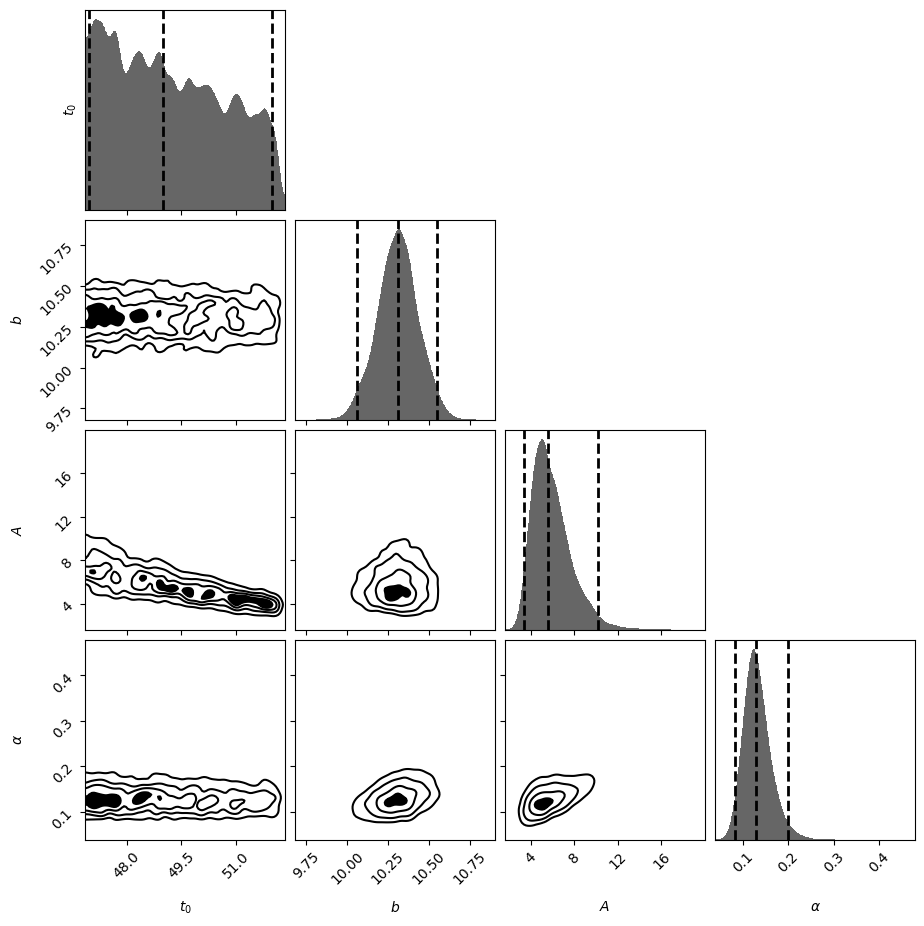

In [57]:
cfig, caxes = dyplot.cornerplot(sresults)
param_names = ["$t_0$", "$b$", "$A$", "$\\alpha$"]

for i, ax in enumerate(caxes[:, 0]):
    ax.set_ylabel(param_names[i])
for i, ax in enumerate(caxes[-1, :]):
    ax.set_xlabel(param_names[i])


In [58]:
##to get credible regions one needs to take into account the weights of the samples!!

def calculate_weighted_credible_interval(samples, weights, credible_level=0.95):
  
    weights = weights / np.sum(weights)
    
    sorted_idx = np.argsort(samples)
    sorted_samples = samples[sorted_idx]
    sorted_weights = weights[sorted_idx]
    cumsum_weights = np.cumsum(sorted_weights)
    
    median_idx = np.searchsorted(cumsum_weights, 0.5)
    median = sorted_samples[median_idx]
    
    alpha = (1 - credible_level) / 2
    lower_idx = np.searchsorted(cumsum_weights, alpha)
    upper_idx = np.searchsorted(cumsum_weights, 1 - alpha)
    
    lower = sorted_samples[lower_idx]
    upper = sorted_samples[upper_idx]
    
    return median, lower, upper

def get_parameter_estimates(results, param_idx, credible_level=0.95):
    
    samples = results.samples[:, param_idx]
    weights = np.exp(results.logwt - results.logz[-1])  
    return calculate_weighted_credible_interval(samples, weights, credible_level)

In [59]:
samples_ns = sresults.samples
credible_level = 0.90

median_t0_ns, lower_t0_ns, upper_t0_ns = get_parameter_estimates(sresults, 0, credible_level)
median_b_ns, lower_b_ns, upper_b_ns = get_parameter_estimates(sresults, 1, credible_level)
median_A_ns, lower_A_ns, upper_A_ns = get_parameter_estimates(sresults, 2, credible_level)
median_alpha_ns, lower_alpha_ns, upper_alpha_ns = get_parameter_estimates(sresults, 3, credible_level)

In [60]:
print(f"t_0 = {median_t0_ns:.2f} +{upper_t0_ns - median_t0_ns:.2f} -{median_t0_ns - lower_t0_ns:.2f}")

print(f"b = {median_b_ns:.2f} +{upper_b_ns - median_b_ns:.2f} -{median_b_ns - lower_b_ns:.2f}")

print(f"A = {median_A_ns:.2f} +{upper_A_ns - median_A_ns:.2f} -{median_A_ns - lower_A_ns:.2f}")

print(f"alpha = {median_alpha_ns:.2f} +{upper_alpha_ns - median_alpha_ns:.2f} -{median_alpha_ns - lower_alpha_ns:.2f}")

t_0 = 49.01 +2.78 -1.93
b = 10.31 +0.20 -0.21
A = 5.60 +3.76 -1.95
alpha = 0.13 +0.06 -0.04


## Let's use a gaussian model instead
$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

In [37]:
#par = [t0, b, A , sigma_W]
#$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$


def model_2 (t, par):
    modello = []
    for time in t:
        modello.append(par[1] + par[2] * np.exp(- (time-par[0])**2 / (2*par[3]**2)))

    return modello


def prior_transform_2(u):
    prior_0 = stats.uniform(30,70).ppf(u[0])
    prior_1 = stats.uniform(0,20).ppf(u[1])
    prior_2 = stats.uniform(0,20).ppf(u[2])
    prior_3 = stats.uniform(np.exp(-5),np.exp(2)).ppf(u[3]) ###mi serve prior sigma_w... quale può essere?
    
                                
    return prior_0, prior_1, prior_2, prior_3

def loglike_normalized_2(par, data = data, model=model_2):

    x = data [:,0]
    y = data [:,1]
    sigma_y = data [:,2]

    y_fit = model(x, par)
       
    return sum ( (stats.norm.logpdf(*args) - np.log(np.sqrt(2*np.pi)*args[2]) for args in zip(y, y_fit, sigma_y)) )


In [38]:
#Nested sampling.
ndim = 4  # number of parameters in the model


sampler_2 = dynesty.NestedSampler(loglike_normalized_2, prior_transform_2, ndim, nlive = 1000)
sampler_2.run_nested()
sresults_2 = sampler_2.results

5874it [13:36,  1.98it/s, bound: 11 | nc: 17 | ncall: 53518 | eff(%): 10.976 | loglstar:   -inf < -270.874 <    inf | logz: -278.153 +/-  0.080 | dlogz: 34.693 >  1.009] /home/malvi/venv/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
6263it [16:15,  3.04it/s, bound: 16 | nc: 12 | ncall: 60975 | eff(%): 10.271 | loglstar:   -inf < -265.649 <    inf | logz: -274.365 +/-  0.087 | dlogz: 31.009 >  1.009] /home/malvi/venv/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are u

In [39]:
sresults_2 = sampler_2.results

# Save the nested sampling results
ns_results_2_file = "nested_sampling_results_2.npy"
np.save(ns_results_2_file, sresults_2)

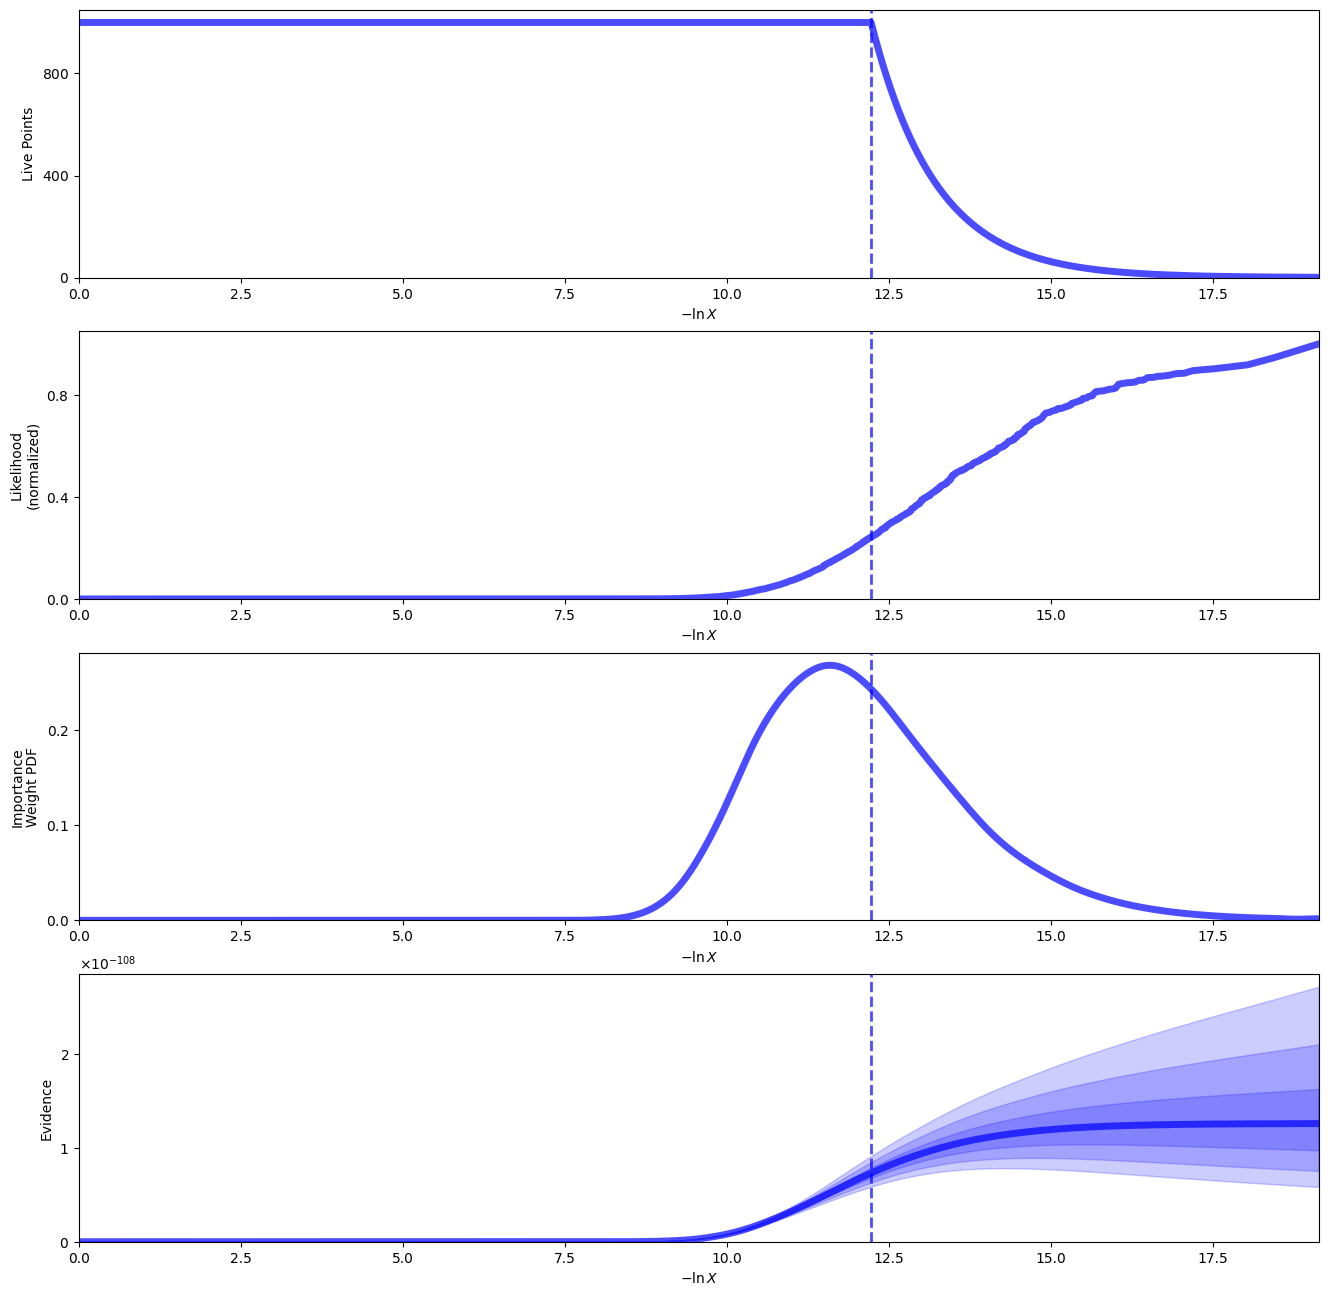

In [40]:
from dynesty import plotting as dyplot
plt.rcParams['figure.figsize'] = (8,8)
rfig, raxes = dyplot.runplot(sresults_2)

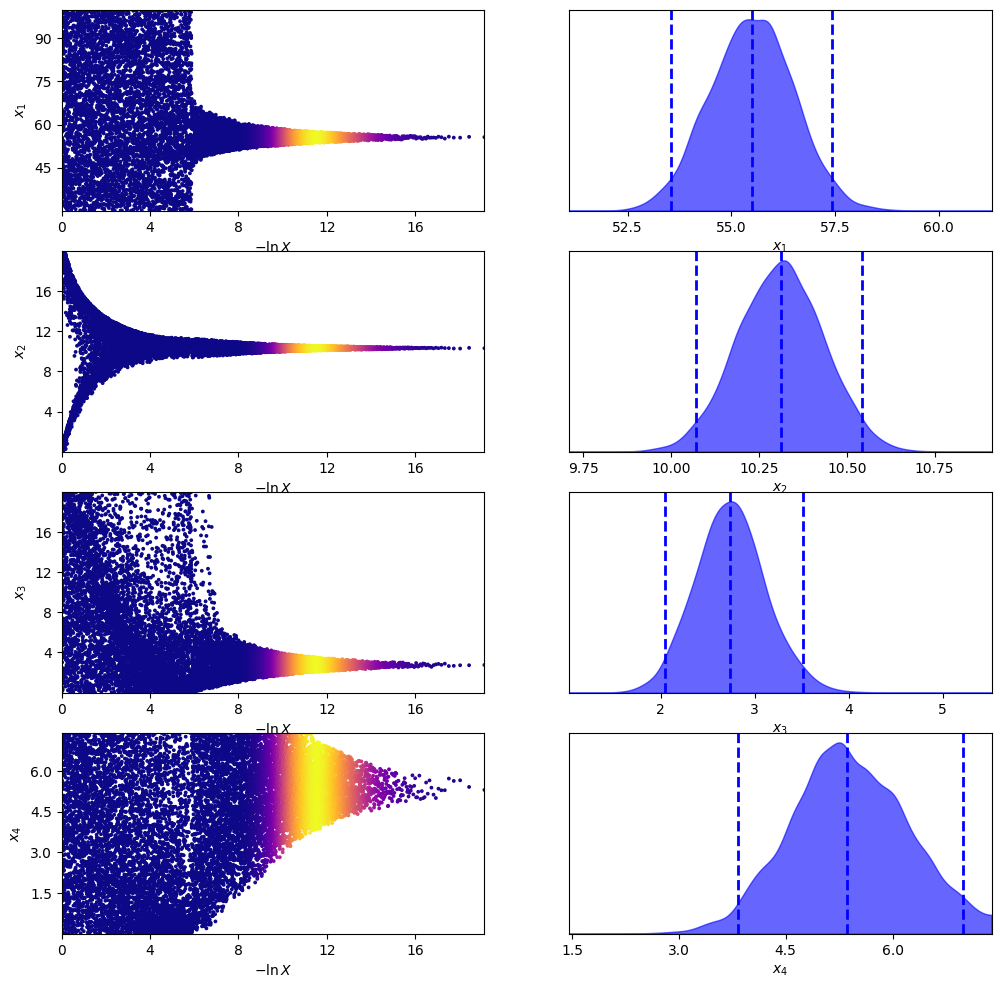

In [41]:
tfig, taxes = dyplot.traceplot(sresults_2)

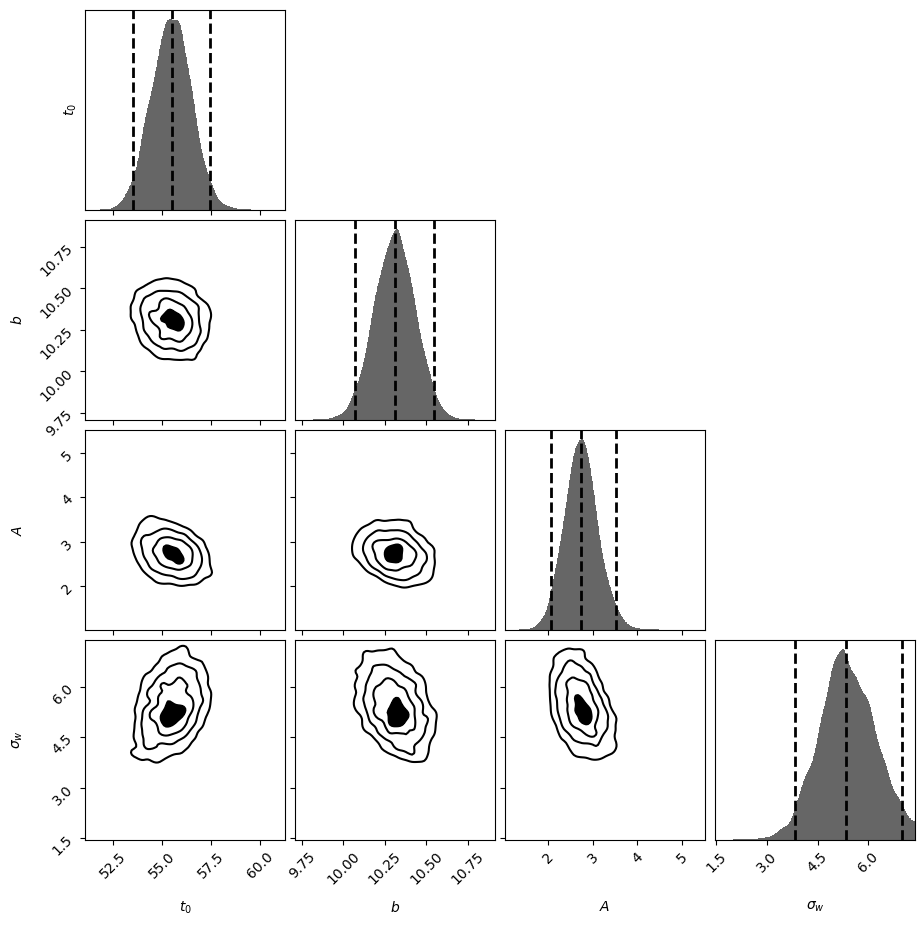

In [62]:
cfig, caxes = dyplot.cornerplot(sresults_2)
param_names = ["$t_0$", "$b$", "$A$", "$\\sigma_w$"]

for i, ax in enumerate(caxes[:, 0]):
    ax.set_ylabel(param_names[i])
for i, ax in enumerate(caxes[-1, :]):
    ax.set_xlabel(param_names[i])


In [66]:
from dynesty import utils as dyfunc

samples_ns_2 = sresults_2.samples
weights_2 = np.exp(sresults_2.logwt - sresults_2.logz[-1])  # normalized weights

quantiles_2= [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_2)
             for samps in samples_ns_2.T]
print('68% parameter credible regions are:\n ' + str(quantiles_2) + '\n')

# Compute weighted mean and covariance.
mean_2, cov_2 = dyfunc.mean_and_cov(samples_ns_2, weights_2)
print('Mean and covariance of parameters are: \n' + str(mean_2) + '\n' + str(cov_2))


68% parameter credible regions are:
 [[54.460657275747344, 56.4869158807182], [10.189254162038939, 10.431745009433596], [2.3719178898683246, 3.097108863686636], [4.592123522556441, 6.225962679876294]]

Mean and covariance of parameters are: 
[55.48988485 10.31060387  2.74292417  5.38735417]
[[ 0.99528996 -0.01741163 -0.11842763  0.26672496]
 [-0.01741163  0.01472904 -0.01037981 -0.0357768 ]
 [-0.11842763 -0.01037981  0.13869886 -0.1193478 ]
 [ 0.26672496 -0.0357768  -0.1193478   0.66348363]]


## To compute which model is best:  Bayes factor


In [67]:
print(" the evidence form the burst model is:" , sresults.logz[-1], "+-", sresults.logzerr[-1], "\n",
        "the evidence from the gaussian model is:", sresults_2.logz[-1], "+-", sresults_2.logzerr[-1])
      

 the evidence form the burst model is: -246.89200541696204 +- 0.28144595327001093 
 the evidence from the gaussian model is: -248.4494928252324 +- 0.2566242866860162


In [44]:
sresults.summary()
sresults_2.summary()

Summary
nlive: 1000
niter: 14442
ncall: 153505
eff(%): 10.060
logz: -246.892 +/-  0.281
Summary
nlive: 1000
niter: 12234
ncall: 89086
eff(%): 14.855
logz: -248.449 +/-  0.257


In [68]:
bayes_factor = np.exp(sresults.logz[-1]) / np.exp(sresults_2.logz[-1])
# error propagation
error_bayes_factor = bayes_factor * np.sqrt((sresults.logzerr[-1] / sresults.logz[-1])**2 + (sresults_2.logzerr[-1] / sresults_2.logz[-1])**2)

print("bayes factor:", bayes_factor, "+-", error_bayes_factor)

bayes factor: 4.746879279159554 +- 0.007302157191875394


since the bayes factor is > 1, the burst model decisively favoured

In [46]:
from dynesty import utils as dyfunc

weights = np.exp(sresults.logwt - sresults.logz[-1]) 
samples_equal = dyfunc.resample_equal(sresults.samples, weights)

weights_2 = np.exp(sresults_2.logwt - sresults_2.logz[-1])
samples_equal_2 = dyfunc.resample_equal(sresults_2.samples, weights_2)

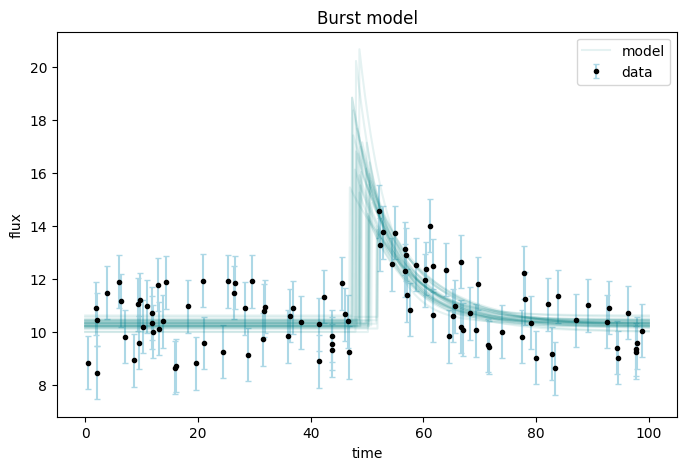

In [47]:
random_par = samples_equal[np.random.choice(len(samples_equal),size=30)]


fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='lightblue', markersize=3, capsize=2, capthick=1, label='data')

yfit = model_(xgrid, random_par[0])
ax.plot(xgrid, yfit, color='teal', alpha=0.1, label='model')

for par_i in random_par:
    yfit = model_(xgrid, par_i)
    ax.plot(xgrid, yfit, color='teal', alpha=0.1)

ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.legend(loc='best', fontsize=10)
ax.set_title('Burst model')
plt.show()

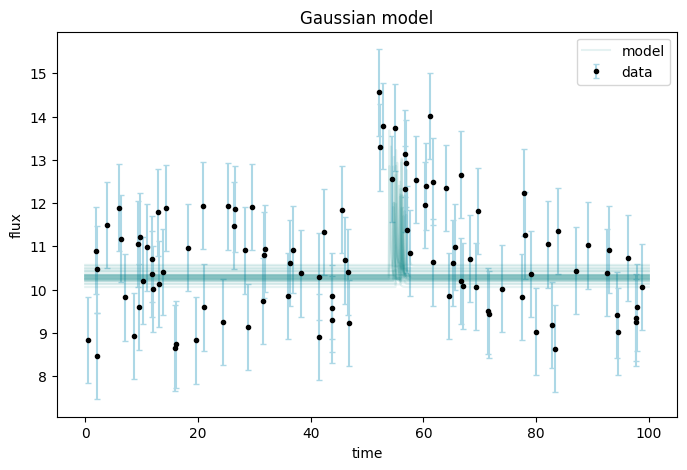

In [48]:
random_par_2 = samples_equal_2[np.random.choice(len(samples_equal_2),size=30)]


fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='lightblue', markersize=3, capsize=2, capthick=1, label='data')

yfit = model_(xgrid, random_par_2[0])
ax.plot(xgrid, yfit, color='teal', alpha=0.1, label='model')

for par_i in random_par_2:
    yfit = model_(xgrid, par_i)
    ax.plot(xgrid, yfit, color='teal', alpha=0.1)

ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.legend(loc='best', fontsize=10)
ax.set_title('Gaussian model')
plt.show()